https://github.com/gslapnicar/bp-estimation-mimic3/blob/master/cleaning_scripts/flat_lines.m  
https://github.com/gslapnicar/bp-estimation-mimic3/blob/master/cleaning_scripts/flat_peaks.m  
https://github.com/gslapnicar/bp-estimation-mimic3/blob/master/cleaning_scripts/main.m

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
#windows
w_flat = 15    # flat lines window
w_peaks = 5    # flat peaks window
w_fix = 15     # flat join window

# thresholds
t_peaks = 0.05 # percentage of tolerated flat peaks
t_flat = 0.05 # percentage of tolerated flat lines

load data


In [2]:
path = r"F:\minowa\BloodPressureEstimation\data\raw\ppgabp\p00\p000652\3019644_0001.npy"
save_dir=r"..\data\processed\test"

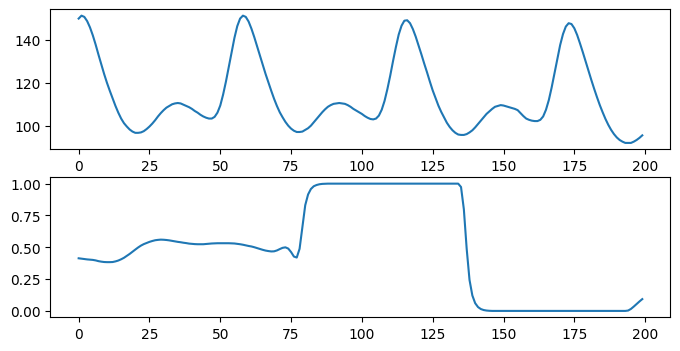

In [67]:
sig = np.load(path)
start = 217600
length=200
end = 111100
fig, axes = plt.subplots(2,1,figsize=(8,4))
axes[0].plot(sig[start:start+length,0])
axes[1].plot(sig[start:start+length,1])


In [5]:
flat = np.sum(sig[1:,0] == sig[:-1,0])
flat

89346

ChatGPT

flat_lines


In [6]:

def flat_lines(data, window, incline, show):
    # Inputs:
    #   data ... 2xN matrix (containing signal PPG in the first and ABP in the second dimension)
    #   window ... size of the sliding window
    #   incline .. boolean, check for a small inclines yi == y(i+1) +- 1
    #   show ... boolean, show plots or not
    # Outputs:
    #   per_ppg/abp ... percentage of points that are considered flat
    
    # Flat line in ABP and PPG -> sliding window over the whole thing
    len_data = data.shape[1]
    flat_locs_abp = np.ones((len_data - window+1,), dtype=int)
    flat_locs_ppg = np.ones((len_data - window+1,), dtype=int)
    # print(flat_locs_abp.shape)
    # Get the locations where i == i+1 == i+2 ... == i+window
    # efficient-ish sliding window
    # print(data[1, :len_data - window].shape,data[1, 0:len_data - window + 0].shape)
    for i in range(1, window):
        # print(data[1, :len_data - window+1].shape, data[1, i:len_data - window + i+1].shape)
        tmp_abp = (data[1, :len_data - window+1] == data[1, i:len_data - window + i+1])
        tmp_ppg = (data[0, :len_data - window+1] == data[0, i:len_data - window + i+1])
        
        # can be generalized -> for loop, if so desired
        if incline:
            # +1
            tmp_abp2 = (data[1, :len_data - window+1] == data[1, i:len_data - window + i+1] + 1)
            tmp_ppg2 = (data[0, :len_data - window+1] == data[0, i:len_data - window + i+1] + 1)
            # -1
            tmp_abp3 = (data[1, :len_data - window+1] == data[1, i:len_data - window + i+1] - 1)
            tmp_ppg3 = (data[0, :len_data - window+1] == data[0, i:len_data - window + i+1] - 1)
            # OR
            tmp_abp = (tmp_abp | tmp_abp2 | tmp_abp3)
            tmp_ppg =(tmp_ppg | tmp_ppg2 | tmp_ppg3)
        
        flat_locs_abp = (flat_locs_abp & tmp_abp)
        flat_locs_ppg = (flat_locs_ppg & tmp_ppg)
    # print(tmp_abp.shape,tmp_ppg.shape)
    # Extend to be the same size as data
    flat_locs_ppg = np.concatenate((flat_locs_ppg, np.zeros((window - 1,), dtype=bool)))
    flat_locs_abp = np.concatenate((flat_locs_abp, np.zeros((window - 1,), dtype=bool)))
    # print(flat_locs_abp.shape,flat_locs_ppg.shape)
    flat_locs_ppg2 = flat_locs_ppg.copy()
    flat_locs_abp2 = flat_locs_abp.copy()
    # print(flat_locs_abp2.shape,flat_locs_ppg2.shape)
    
    # Mark the ends of the window
    for i in range(1, window):
        flat_locs_abp[i:] = flat_locs_abp[i:] | flat_locs_abp2[:len_data-i]
        flat_locs_ppg[i:] = flat_locs_ppg[i:] | flat_locs_ppg2[:len_data-i]
    
    # Percentages
    per_abp = np.sum(flat_locs_abp) / len_data
    per_ppg = np.sum(flat_locs_ppg) / len_data
    # print(np.sum(flat_locs_abp) ,np.sum(flat_locs_ppg))
    print(np.where(flat_locs_abp)[0][:50])
    if show:
        # Plot the flat line points
        x = np.arange(1, len_data+1)
        plt.subplot(2, 1, 1)
        plt.plot(x, data[0, :], 'black',linewidth=1)
        plt.scatter(x[np.where(flat_locs_ppg)[0]], data[0, np.where(flat_locs_ppg)[0]], color='red',s=24)
        
        plt.subplot(2, 1, 2)
        plt.plot(x, data[1, :], 'black',linewidth=1)
        plt.scatter(x[np.where(flat_locs_abp)[0]], data[1, np.where(flat_locs_abp)[0]], color='red',s=24)
        
        plt.show()
    
    return per_ppg, per_abp

[   360    361    362    363    364    365    366    367    368    369
    370    371    372    373    374 110957 110958 110959 110960 110961
 110962 110963 110964 110965 110966 110967 110968 110969 110970 110971
 148563 148564 148565 148566 148567 148568 148569 148570 148571 148572
 148573 148574 148575 148576 148577 148578 148579 217688 217689 217690]


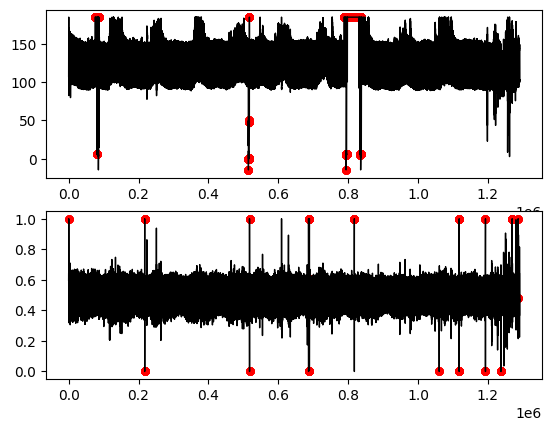

(0.037414681386790626, 0.0014875072632190586)

In [21]:
per_ppg, per_abp = flat_lines(sig.T,w_flat,False,True)
per_ppg,per_abp

flat_peaks

In [8]:
def flat_peaks(signal, abp_peaks, abp_valleys, ppg_peaks, ppg_valleys, abp_thresh, ppg_thresh, window, graphs):
    # This function checks the signal for flat peaks. Flat peaks are an anomaly in the collected data
    # and such signals are not useful, thus must be discarded.
    #
    # Input:
    #   signal  ... signal for current patient (ABP and PPG)
    #   abp_peaks   ... peak locations for ABP
    #   ppg_peaks   ... peak locations for PPG                  
    #   abp_valleys ... cycle start/end points for ABP
    #   ppg_valleys ... cycle start/end points for PPG          
    #   ppg_thresh / abp_thresh ... threshold amount (fraction or %) of flat peaks that must be exceeded in order for this signal to be discarded
    #   window    ... how many points are considered a flat line/top
    # Output:
    #   skip_ppg/skip_abp ... binary values, 1 = skip this signal due to flat peaks, 0 = keep this signal

    # show the plots or not
    if graphs:
        show = True
    else:
        show = False
    
    number_of_peaks_abp = len(abp_peaks)
    number_of_valleys_abp = len(abp_valleys)

    number_of_peaks_ppg = len(ppg_peaks)
    number_of_valleys_ppg = len(ppg_valleys)

    # first get the flat lines:
    len = signal.shape[1]
    flat_locs_abp = np.ones((1, len-window+1))
    flat_locs_ppg = np.ones((1, len-window+1))

    # get the locations where i == i+1 == i+2 ... == i+window
    # efficient-ish sliding window
    for i in range(1, window+1):
        flat_locs_abp = flat_locs_abp & (signal[1, 0:len-window+1] == signal[1, i:len-window+i])
        flat_locs_ppg = flat_locs_ppg & (signal[0, 0:len-window+1] == signal[0, i:len-window+i])

    # extend to be the same size as data
    flat_locs_ppg = np.concatenate((flat_locs_ppg, np.zeros((1, window-1))), axis=1)
    flat_locs_abp = np.concatenate((flat_locs_abp, np.zeros((1, window-1))), axis=1)

    # additional arrays
    abp_peak_ones = np.zeros((1, signal.shape[1]))
    abp_peak_ones[0, abp_peaks] = 1
    abp_valley_ones = np.zeros((1, signal.shape[1]))
    abp_valley_ones[0, abp_valleys] = 1
    ppg_peak_ones = np.zeros((1, signal.shape[1]))
    ppg_peak_ones[0, ppg_peaks] = 1
    ppg_valley_ones = np.zeros((1, signal.shape[1]))
    ppg_valley_ones[0, ppg_valleys] = 1

    # extract the needed info:
    locs_of_flat_peaks_abp = np.where(flat_locs_abp & abp_peak_ones)
    locs_of_flat_valleys_abp = np.where(flat_locs_abp & abp_valley_ones)
    number_of_flat_peaks_abp = locs_of_flat_peaks_abp.shape[1]
    number_of_flat_valleys_abp = locs_of_flat_valleys_abp.shape[1]

    locs_of_flat_peaks_ppg = np.where(flat_locs_ppg & ppg_peak_ones)
    locs_of_flat_valleys_ppg = np.where(flat_locs_ppg & ppg_valley_ones)
    number_of_flat_peaks_ppg = locs_of_flat_peaks_ppg.shape[1]
    number_of_flat_valleys_ppg = locs_of_flat_valleys_ppg.shape[1]

    # thresholding and plotting
    skip_ppg = 0
    skip_abp = 0
    abp_conclusion = ' KEEP!'
    ppg_conclusion = ' KEEP!'
    abp_mark = '*g'
    ppg_mark = '*g'

    if (number_of_flat_peaks_abp >= abp_thresh*number_of_peaks_abp) or (number_of_flat_valleys_abp >= abp_thresh*number_of_valleys_abp):
        abp_conclusion = ' SKIP!'
        abp_mark = '*r'
        skip_abp = 1

    if (number_of_flat_peaks_ppg >= ppg_thresh*number_of_peaks_ppg) or (number_of_flat_valleys_ppg >= ppg_thresh*number_of_valleys_ppg):
        ppg_conclusion = ' SKIP!'
        ppg_mark = '*r'
        skip_ppg = 1

    if show and (skip_abp or skip_ppg):
        print(skip_abp)
        print(skip_ppg)
        print(f'This ABP signal has more than 10% flat peaks, thus{abp_conclusion}')
        plt.figure()
        plt.plot(signal[1])
        plt.hold(True)
        plt.plot(np.unique(locs_of_flat_peaks_abp), signal[1, locs_of_flat_peaks_abp], abp_mark)
        plt.plot(np.unique(locs_of_flat_valleys_abp), signal[1, locs_of_flat_valleys_abp], abp_mark)
        plt.title(f'ABP{abp_conclusion}')
        plt.hold(False)

        print(f'This signal PPG has more than 10% flat peaks, thus{ppg_conclusion}')
        plt.figure()
        plt.plot(signal[0])
        plt.hold(True)
        plt.plot(np.unique(locs_of_flat_peaks_ppg), signal[0, locs_of_flat_peaks_ppg], ppg_mark)
        plt.plot(np.unique(locs_of_flat_valleys_ppg), signal[0, locs_of_flat_valleys_ppg], ppg_mark)
        plt.title(f'PPG{ppg_conclusion}')
        plt.hold(False)

    return skip_ppg, skip_abp

In [9]:
# def flat_peaks(signal, abp_peaks, abp_valleys, ppg_peaks, ppg_valleys, abp_thresh, ppg_thresh, window, graphs):
        # [~, ppg_peaks] = findpeaks(data(1,:)); [~, ppg_valleys] = findpeaks(-1 * data(1,:));
        # [~, abp_peaks] = findpeaks(data(2,:)); [~, abp_valleys] = findpeaks(-1 * data(2,:));
        # [a,b] = flat_peaks(data, abp_peaks,abp_valleys,ppg_peaks,ppg_valleys, t_peaks, t_peaks, w_peaks, true);


# a,b = flat_peaks(sig,)

In [10]:
len(peaks_ppg)
peaks_info_ppg.keys()

np.where(peaks_info_ppg['plateau_sizes']>w_peaks)[0]


NameError: name 'peaks_ppg' is not defined

45631 45631
0.013566330576639855 0.0019723433630645833


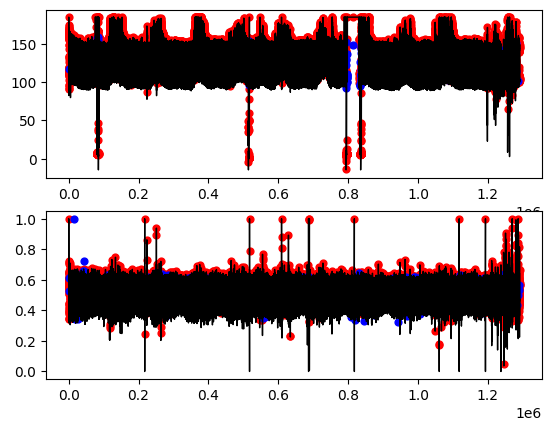

In [ ]:
peaks_ppg, peaks_info_ppg = signal.find_peaks(sig[:,0],plateau_size=1)
peaks_abp, peaks_info_abp = signal.find_peaks(sig[:,1],plateau_size=1)
print(len(peaks_ppg),len(peaks_info_ppg['plateau_sizes']))
len_data=len(sig)
per_abp =len(np.where(peaks_info_ppg['plateau_sizes']>w_peaks)[0])/ len(peaks_info_ppg['plateau_sizes'])
per_ppg =len(np.where(peaks_info_abp['plateau_sizes']>w_peaks)[0])/len(peaks_info_abp['plateau_sizes'])
print(per_ppg,per_abp)
x = np.arange(0, len_data)
plt.subplot(2, 1, 1)
plt.plot(x, sig[:, 0], 'black',linewidth=1)
plt.scatter(x[peaks_ppg], sig[peaks_ppg,0], color='red',s=24)
plt.scatter(x[peaks_ppg[np.where(peaks_info_ppg['plateau_sizes']>w_peaks)[0]]], sig[np.where(peaks_info_ppg['plateau_sizes']>w_peaks)[0],0], color='blue',s=24)

plt.subplot(2, 1, 2)
plt.plot(x, sig[:, 1], 'black',linewidth=1)
plt.scatter(x[peaks_abp], sig[ peaks_abp, 1], color='red',s=24)
plt.scatter(x[peaks_abp[np.where(peaks_info_abp['plateau_sizes']>w_peaks)[0]]], sig[np.where(peaks_info_abp['plateau_sizes']>w_peaks)[0], 1], color='blue',s=24)

plt.show()

In [ ]:
# plateau_length_ppg = peaks_info_ppg['right_edges'] - peaks_info_ppg['left_edges']
# plateau_length_abp = peaks_info_abp['right_edges'] - peaks_info_abp['left_edges']


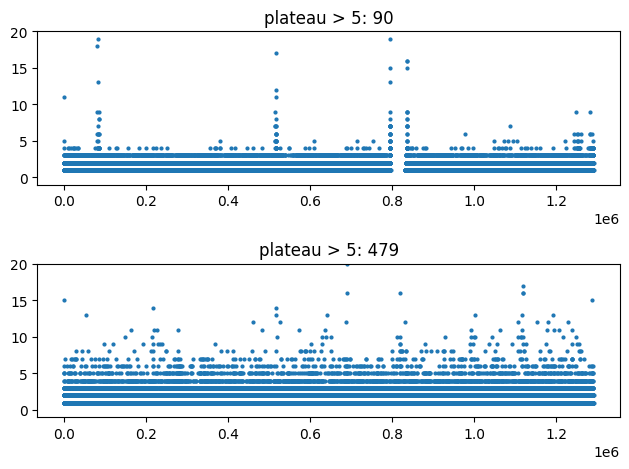

In [ ]:
plt.subplot(2,1,1)
plt.scatter(peaks_ppg,peaks_info_ppg['plateau_sizes'],s=4)
plt.title(f"plateau > 5: {len(np.where(peaks_info_ppg['plateau_sizes']>w_peaks)[0])}")
plt.ylim(-1,20)
plt.subplot(2,1,2)
plt.scatter(peaks_abp,peaks_info_abp['plateau_sizes'],s=4)
plt.title(f"plateau > 5: {len(np.where(peaks_info_abp['plateau_sizes']>w_peaks)[0])}")
plt.ylim(-1,20)
plt.tight_layout()

In [ ]:
ppg_1 = 10
ppg_2 = 15
abp_1 = 60
abp_2 = 65
print(np.where(peaks_info_ppg['plateau_sizes']>w_peaks)[0][ppg_1:ppg_2])
print(np.where(peaks_info_abp['plateau_sizes']>w_peaks)[0][abp_1:abp_2])

[2900 2903 2904 2909 2910]
[5917 5918 5919 5920 5921]


In [ ]:
plateau_ppg = np.where(peaks_info_ppg['plateau_sizes']>w_peaks)[0]
plateau_abp = np.where(peaks_info_abp['plateau_sizes']>w_peaks)[0]
target_x_ppg = x[peaks_ppg[plateau_ppg[ppg_1]]:peaks_ppg[plateau_ppg[ppg_2]]]
target_y_ppg = sig[peaks_ppg[plateau_ppg[ppg_1]]:peaks_ppg[plateau_ppg[ppg_2]],0]
target_x_abp =x[peaks_abp[plateau_abp[abp_1]]:peaks_abp[plateau_abp[abp_2]]]
target_y_abp = sig[peaks_abp[plateau_abp[abp_1]]:peaks_abp[plateau_abp[abp_2]],1]
target_x_ppg[:5],target_y_ppg[:5],target_x_abp[:5],target_y_abp[:5]

(array([83985, 83986, 83987, 83988, 83989]),
 array([185.20220678, 185.20220678, 185.20220678, 185.20220678,
        185.20220678]),
 array([217711, 217712, 217713, 217714, 217715]),
 array([1., 1., 1., 1., 1.]))

In [ ]:
x[peaks_ppg[plateau_ppg[ppg_1:ppg_2]]]

array([83985, 84208, 84252, 84391, 84544])

2900 2925 5917 5922
[326  19  23   6 266] [47  6  6  9  7]


(217711.0, 218031.0)

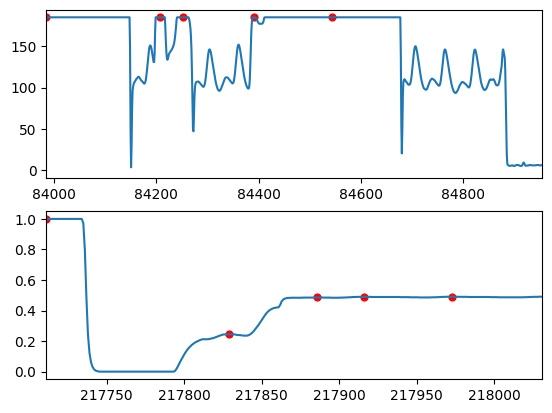

In [ ]:

print(plateau_ppg[ppg_1],plateau_ppg[ppg_2],plateau_abp[abp_1],plateau_abp[abp_2])
print(peaks_info_ppg['plateau_sizes'][plateau_ppg[ppg_1:ppg_2]],peaks_info_abp['plateau_sizes'][plateau_abp[abp_1:abp_2]])
plt.figure()
plt.subplot(2,1,1)
plt.plot(target_x_ppg,target_y_ppg,0)
plt.scatter(x[peaks_ppg[plateau_ppg[ppg_1:ppg_2]]], sig[peaks_ppg[plateau_ppg[ppg_1:ppg_2]],0], color='red',s=24)
plt.xlim(target_x_ppg[0],target_x_ppg[-1])
plt.subplot(2,1,2)
plt.plot(target_x_abp,target_y_abp,1)
plt.scatter(x[peaks_abp[plateau_abp[abp_1:abp_2]]], sig[peaks_abp[plateau_abp[abp_1:abp_2]],1], color='red',s=24)
plt.xlim(target_x_abp[0],target_x_abp[-1])

In [ ]:
target_y_ppg_2 = sig[:,0].copy()
print(target_y_ppg_2.shape)
target_y_abp_2 = sig[:,1].copy()

(1290750,)


In [ ]:
for i in range(len(plateau_ppg)):
    left = peaks_info_ppg['left_edges'][plateau_ppg[i]]
    right = peaks_info_ppg['right_edges'][plateau_ppg[i]]
    print(i,left,right,peaks_info_ppg['plateau_sizes'][plateau_ppg[i]])
    # print(target_y_ppg_2[left-5:right+5])
    target_y_ppg_2[left:right]=np.nan
for i in range(len(plateau_abp)):
    left = peaks_info_abp['left_edges'][plateau_abp[i]]
    right = peaks_info_abp['right_edges'][plateau_abp[i]]
    print(i,left,right,peaks_info_abp['plateau_sizes'][plateau_abp[i]])
    target_y_abp_2[left:right]=np.nan
    
    

0 341 351 11
1 75805 76948 1144
2 77951 78491 541
3 80307 80324 18
4 81878 81883 6
5 81912 81920 9
6 82069 82075 7
7 82186 82191 6
8 82381 82393 13
9 82732 83417 686
10 83823 84148 326
11 84199 84217 19
12 84241 84263 23
13 84389 84394 6
14 84412 84677 266
15 84952 84959 8
16 84976 84984 9
17 85012 85019 8
18 85038 85043 6
19 85256 85261 6
20 86565 86641 77
21 514899 514905 7
22 515087 515095 9
23 515105 515111 7
24 515125 515407 283
25 515867 515872 6
26 516001 516006 6
27 516083 516089 7
28 516287 516294 8
29 516355 516365 11
30 516461 516472 12
31 516493 516498 6
32 516509 516515 7
33 516540 516556 17
34 516560 516587 28
35 517288 517293 6
36 517427 517479 53
37 787893 790292 2400
38 790535 792059 1525
39 793387 794230 844
40 794361 794367 7
41 794577 794583 7
42 794614 794634 21
43 794667 794691 25
44 794715 794721 7
45 795030 795036 7
46 795112 795130 19
47 795139 795151 13
48 795160 795165 6
49 795215 795220 6
50 795472 795478 7
51 795631 795637 7
52 795712 795717 6
53 795749 795

In [ ]:
target_y_ppg_2 = target_y_ppg_2[peaks_ppg[plateau_ppg[ppg_1]]:peaks_ppg[plateau_ppg[ppg_2]]]
target_y_abp_2 = target_y_abp_2[peaks_abp[plateau_abp[abp_1]]:peaks_abp[plateau_abp[abp_2]]]

In [ ]:
print(target_y_abp_2.shape)

(321,)


2900 2925 5917 5922
[326  19  23   6 266] [47  6  6  9  7]


(217711.0, 218031.0)

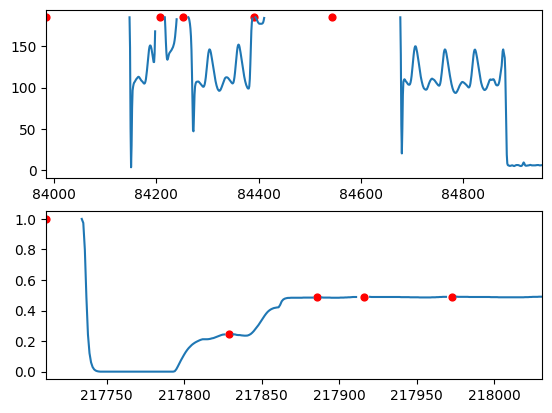

In [ ]:
print(plateau_ppg[ppg_1],plateau_ppg[ppg_2],plateau_abp[abp_1],plateau_abp[abp_2])
print(peaks_info_ppg['plateau_sizes'][plateau_ppg[ppg_1:ppg_2]],peaks_info_abp['plateau_sizes'][plateau_abp[abp_1:abp_2]])
plt.figure()
plt.subplot(2,1,1)
plt.plot(target_x_ppg,target_y_ppg_2,0)
plt.scatter(x[peaks_ppg[plateau_ppg[ppg_1:ppg_2]]], sig[peaks_ppg[plateau_ppg[ppg_1:ppg_2]],0], color='red',s=24)
plt.xlim(target_x_ppg[0],target_x_ppg[-1])
plt.subplot(2,1,2)
plt.plot(target_x_abp,target_y_abp_2,1)
plt.scatter(x[peaks_abp[plateau_abp[abp_1:abp_2]]], sig[peaks_abp[plateau_abp[abp_1:abp_2]],1], color='red',s=24)
plt.xlim(target_x_abp[0],target_x_abp[-1])

In [ ]:
target_y_ppg_2.shape,target_y_abp_2.shape

((1290750,), (1290750,))

In [ ]:
np.stack([target_y_ppg_2,target_y_abp_2]).shape

(2, 1290750)

[110957 110958 110959 110960 110961 110962 110963 110964 110965 110966
 110967 110968 110969 110970 110971 148563 148564 148565 148566 148567
 148568 148569 148570 148571 148572 148573 148574 148575 148576 148577
 148578 148579 217746 217747 217748 217749 217750 217751 217752 217753
 217754 217755 217756 217757 217758 217759 217760 217761 217762 217763]


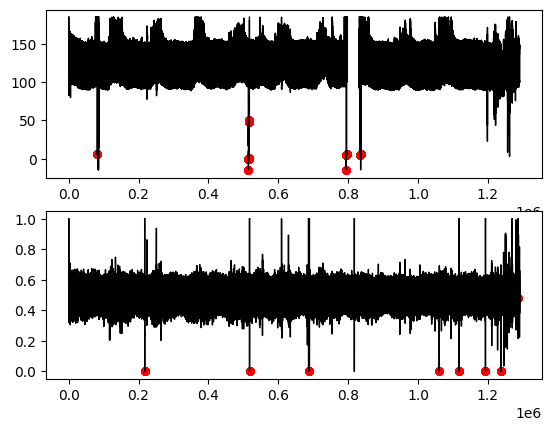

(0.0013976370327329073, 0.0010257602169281425)

In [ ]:
per_ppg, per_abp = flat_lines(np.stack([target_y_ppg_2,target_y_abp_2]),w_flat,False,True)
per_ppg,per_abp

In [ ]:
plt.

1. flat_lines()内のfor文(sliding window)でflat lines, peaks検知
2. flat linesが全体の10％以上なら削除
3. find_peaks()でflat peaksの割合検知 
4. cycleの5%がflat peaks ,波形全体の10%がflat linesなら削除 
5. find_peaks(sig*-1)でvalleys検出
6. flat linesが存在するvalley-valley間(cycle)をnanで埋める (本家ではPPG基準でABPはPPGに巻き込まれて消える)
7. (optional)nanを消して圧縮(abp ppgでorをとる), 境界をメモっておく？

In [ ]:
w_flat = 15    # flat lines window
w_peaks = 5    # flat peaks window
w_fix = 15     # flat join window

# thresholds
t_peaks = 0.05 # percentage of tolerated flat peaks
t_flat = 0.1  # percentage of tolerated flat lines

In [26]:
# 1
def detect_flat(sig,window):
    sig = sig.T
    len_data = sig.shape[1]
    flat_locs_abp = np.ones((len_data - window+1,), dtype=int)
    flat_locs_ppg = np.ones((len_data - window+1,), dtype=int)
    # print(flat_locs_abp.shape)
    # Get the locations where i == i+1 == i+2 ... == i+window
    # efficient-ish sliding window
    # print(data[1, :len_data - window].shape,data[1, 0:len_data - window + 0].shape)
    for i in range(1, window):
        # print(data[1, :len_data - window+1].shape, data[1, i:len_data - window + i+1].shape)
        tmp_abp = (sig[1, :len_data - window+1] == sig[1, i:len_data - window + i+1])
        tmp_ppg = (sig[0, :len_data - window+1] == sig[0, i:len_data - window + i+1])
        flat_locs_abp = (flat_locs_abp & tmp_abp)
        flat_locs_ppg = (flat_locs_ppg & tmp_ppg)
        # print(tmp_abp.shape,tmp_ppg.shape)
        # Extend to be the same size as data
    flat_locs_ppg = np.concatenate((flat_locs_ppg, np.zeros((window - 1,), dtype=bool)))
    flat_locs_abp = np.concatenate((flat_locs_abp, np.zeros((window - 1,), dtype=bool)))
    # print(flat_locs_abp.shape,flat_locs_ppg.shape)
    flat_locs_ppg2 = flat_locs_ppg.copy()
    flat_locs_abp2 = flat_locs_abp.copy()
    # print(flat_locs_abp2.shape,flat_locs_ppg2.shape)
        
    # Mark the ends of the window
    for i in range(1, window):
        flat_locs_abp[i:] = flat_locs_abp[i:] | flat_locs_abp2[:len_data-i]
        flat_locs_ppg[i:] = flat_locs_ppg[i:] | flat_locs_ppg2[:len_data-i]
        
    # Percentages
    per_abp = np.sum(flat_locs_abp) / len_data
    per_ppg = np.sum(flat_locs_ppg) / len_data
    if per_abp > t_flat or per_ppg > t_flat:
        print(f"invalid because of flat lines: {per_ppg}, {per_abp},{np.sum(flat_locs_abp)},{np.sum(flat_locs_ppg)},{np.nanmax(flat_locs_abp)},{np.nanmax(flat_locs_ppg)}")
        return True,None,None
    else:
        return False,flat_locs_ppg,flat_locs_abp
            
    

In [125]:
def main(sig,plot=False,xfrom=0,xlen=100000):
    w_flat = 15    # flat lines window
    w_peaks = 5    # flat peaks window
    w_fix = 15     # flat join window
    w_nan = 125 * 120
    # thresholds
    t_peaks = 0.05 # percentage of tolerated flat peaks
    t_flat = 0.1  # percentage of tolerated flat lines
    if plot:
        sig_processed = sig.copy()
    # 0 nanでorをとる
    nan_mask = np.isnan(sig[:,0]) | np.isnan(sig[:,1])
    sig[nan_mask] = np.nan
    
    # 1, 2
    is_invalid,flat_locs_ppg,flat_locs_abp=detect_flat(sig,w_flat)
    if is_invalid:
        return
    # 3
    peaks_ppg, peaks_info_ppg = signal.find_peaks(sig[:,0],distance=35,plateau_size=1)
    peaks_abp, peaks_info_abp = signal.find_peaks(sig[:,1],distance=35,plateau_size=1)
    # 4
    len_data=len(sig)
    per_abp =len(np.where(peaks_info_ppg['plateau_sizes']>w_peaks)[0])/ len(peaks_info_ppg['plateau_sizes'])
    per_ppg =len(np.where(peaks_info_abp['plateau_sizes']>w_peaks)[0])/len(peaks_info_abp['plateau_sizes'])
    # del
    if per_abp > t_peaks or per_ppg > t_peaks:
        print(f"invalid because of flat lines: {per_ppg}, {per_abp}")
        return
    # 5
    valleys_ppg, _ = signal.find_peaks(-sig[:,0],distance=35)
    valleys_abp, _ = signal.find_peaks(-sig[:,1],distance=35)
    # 6 nan
    # connect_valley_locs_???[i] = True if there's flat line between valleys[i] and valleys[i+1] 
    # ppg
    connect_valley_locs_ppg = np.zeros_like(valleys_ppg)
    for i in range(valleys_ppg.shape[0]-1):
        connect_valley_locs_ppg[i] = np.any(flat_locs_ppg[valleys_ppg[i]:valleys_ppg[i+1]])
    print("total connecting valleys:",np.sum(connect_valley_locs_ppg),valleys_ppg.shape[0]-1)
    for j in range(connect_valley_locs_ppg.shape[0]-1):
        if connect_valley_locs_ppg[j]:
            sig[valleys_ppg[j]:valleys_ppg[j+1],:]=np.nan 
    # abp
    connect_valley_locs_abp = np.zeros_like(valleys_abp)
    for i in range(valleys_abp.shape[0]-1):
        connect_valley_locs_abp[i] = np.any(flat_locs_abp[valleys_abp[i]:valleys_abp[i+1]])
    for j in range(connect_valley_locs_abp.shape[0]-1):
        if connect_valley_locs_abp[j]:
            sig[valleys_abp[j]:valleys_abp[j+1],:]=np.nan 
    
    # 7 nan del
    starts_with_nan = np.isnan(sig[0,0])
    nan_diff = np.diff(np.isnan(sig[:,0]))
    nan_border = np.where(nan_diff==1)[0]
    if not starts_with_nan:
        nan_border = nan_border[1:-1]
    nan_border = nan_border.reshape(-1,2)
    nan_length = nan_border[:,1]-nan_border[:,0]
    
    # print(nan_border[:5],nan_length[:30])
    for i,l in enumerate(nan_length):
        if l < w_nan:
            sig[nan_border[i,0]:nan_border[i,1],:]=np.nan
    # print(len(nan_diff_pos),nan_diff_pos[:5],len(nan_diff_neg),nan_diff_neg[:5])
    nan_mask = np.isnan(sig[:,0])
    # leave single nan
    nan_border = nan_border[np.where(nan_length < w_nan)[0]]
    nan_mask[nan_border] = False
    sig = sig[~nan_mask,:]
    print("before:",len_data,"after:",len(sig))
    if plot:
        x = np.arange(0,len(sig))
        plt.figure(figsize=(12,4))
        plt.subplot(2,1,1)
        # plt.plot(x,sig_processed[:,0],label='-.',color='black')
        plt.plot(x,sig[:,0])
        # plt.scatter(x[valleys_ppg], sig[valleys_ppg,0], color='red',s=24)
        plt.xlim(xfrom,xfrom+xlen)
        plt.subplot(2,1,2)
        # plt.plot(x,sig_processed[:,1],label='-.',color='black')
        plt.plot(x,sig[:,1])
        # plt.scatter(x[valleys_abp], sig[valleys_abp,1], color='red',s=24)
        plt.xlim(xfrom,xfrom+xlen)
        plt.show()
    return sig

In [15]:
sig.shape

(1290750, 2)

In [195]:
sig = np.load(path)


In [197]:
%%timeit
sig = np.load(path)
# sig[0:10,1] = np.nan
notnan= ~np.isnan(sig[:,0])
sig[notnan,0] = butterworth(sig[notnan,0])

40.6 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [198]:
%%timeit
sig = np.load(path)
sig = sig[~(np.isnan(sig[:,0]) | np.isnan(sig[:,1]))]
sig[:,0] = butterworth(sig[:,0])

44.2 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [146]:
np.sum(np.isnan(sig[:,1]))

0

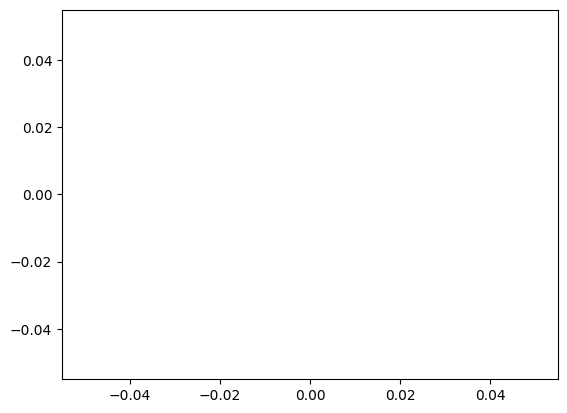

In [142]:
plt.plot(sig[:,1])

total connecting valleys: 0 22913
before: 1290750 after: 1255907


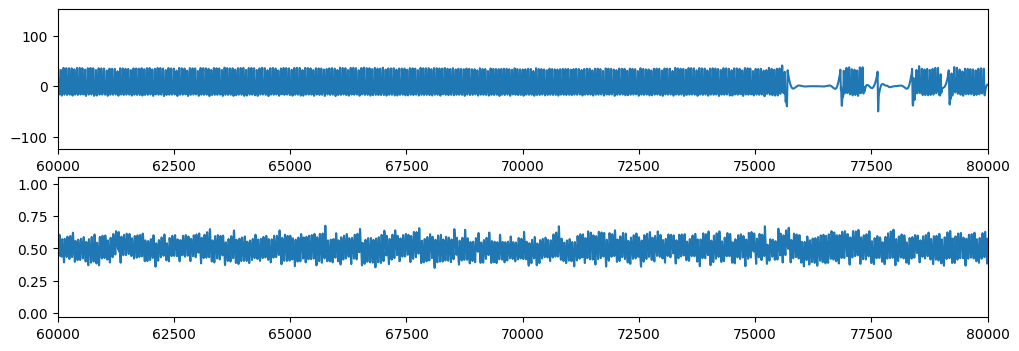

In [202]:
xfrom = 60000
xlen= 20000
sig 
sig2 = main(sig,True,xfrom=xfrom,xlen=xlen)

In [119]:
print(np.sum(np.isnan(sig2)))

80


In [60]:
valleys_ppg, _ = signal.find_peaks(-sig[:,0])
len(valleys_ppg)

45630

### A